## Task2:机器学习用于真实时间序列预测

### 数据导入并绘制序列

In [115]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
torch.set_default_tensor_type(torch.DoubleTensor)

In [116]:
# 数据导入
data = pd.read_csv('exp3data/alcohol.csv', index_col=0)
data = data.dropna().interpolate(method='linear')
data.head(13)

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
1992-06-01,4529
1992-07-01,4466
1992-08-01,4137
1992-09-01,4126


In [117]:
# 绘制序列
def plot_series(time, series, format="-", start=0, end=None, label=None):
    # 根据时间轴和对应数据列表绘制序列图
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例说明字体大小
    if label:
        plt.legend(fontsize=14)
    # 设置网格线
    plt.grid(True)

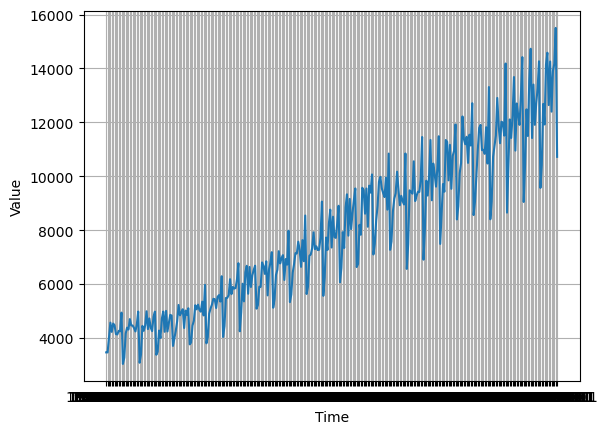

In [118]:
plot_series(data.index, data['S4248SM144NCEN'])

### 数据处理

1. 划分训练集、测试集

In [119]:
def train_test_split(series, split_prop):
    train = series[:int(split_prop * int(series.size))]
    test = series[int(split_prop * int(series.size)):]
    return train, test

2. 滑窗、划分特征/标签函数

In [120]:
def data_process(train, test, window_size):
    # 将数据直接转为tensor
    train_tensor = torch.tensor(train.values).squeeze(1)
    test_tensor = torch.tensor(test.values).squeeze(1)
    
    # 滑窗，得到短序列
    train_window_split = train_tensor.unfold(0, window_size, 1)
    train_set = train_window_split.numpy()
     
    test_window_split = test_tensor.unfold(0, window_size, 1)
    test_set = test_window_split.numpy()
    
    # 打乱训练集短序列数据
    train_templ = train_set.tolist()
    random.shuffle(train_templ)
    train_templ2 = np.array(train_templ)
    
    # 将短序列划分为feature和label
    train_feature_array = train_templ2[:, :window_size-1]
    train_label_array = train_templ2[:, window_size-1:]
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]
    
    # 转为tensor
    train_feature = torch.tensor(train_feature_array)
    train_label_temp = torch.tensor(train_label_array)
    test_feature = torch.tensor(test_feature_array)
    test_label_temp = torch.tensor(test_label_array)
    
    # 将label张量降维，去除维度为1的维度
    train_label = train_label_temp.squeeze()
    test_label = test_label_temp.squeeze()
    
    return train_feature, train_label, test_feature, test_label

3. 划分batch函数

In [121]:
# 将数据划分为指定大小的batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        # 最后一次可能不足一个batch
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) 
        yield  features.index_select(0, j), labels.index_select(0, j)

4. 设置划分比例进行划分，设置滑窗大小将长序列变为短序列、划分特征与标签等

In [122]:
split_prop = 0.7
train, test = train_test_split(data, split_prop)
window_size = 13 # 12+1
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

torch.Size([215, 12])
torch.Size([215])
torch.Size([86, 12])
torch.Size([86])


### 神经网络

构建3层前馈神经网络

In [123]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)
    
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 12, 1, 3

# 定义模型
net1 = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

In [124]:
# 损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / (y.shape[0])

learning rate = 0.1

In [125]:
# 参数初始化
for params in net1.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    
lr = 0.1
num_epochs = 200
batch_size = 64
loss = squared_loss
# loss = nn.MSELoss() # 均方误差损失函数
optimizer = torch.optim.Adam(net1.parameters(), lr=lr) # Adam优化器

训练模型

In [126]:
train_loss = []
test_loss = []

# 模型训练
for epoch in range(num_epochs): # 外循环训练一轮
    train_l, test_l = 0.0, 0.0
    for X, y in data_iter(batch_size, train_feature, train_label): # 内循环训练一个batch
        X = X.double()
        y = y.double()
        y_hat = net1(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        
    # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）
    train_feature = train_feature.double()  
    train_label = train_label.double()  
    test_feature = test_feature.double() 
    test_label = test_label.double()  
    train_l = loss(net1(train_feature), train_label).mean().item()
    test_l = loss(net1(test_feature), test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))

epoch 0, train loss 47045.187735, test loss 345601.892811
epoch 1, train loss 14471.754556, test loss 107730.642020
epoch 2, train loss 16094.872129, test loss 119544.483822
epoch 3, train loss 19017.111453, test loss 141061.392717
epoch 4, train loss 6104.987034, test loss 46729.868364
epoch 5, train loss 5387.202756, test loss 41474.307381
epoch 6, train loss 7173.624010, test loss 54543.706831
epoch 7, train loss 4247.260749, test loss 33107.450857
epoch 8, train loss 2615.063250, test loss 21184.750751
epoch 9, train loss 3282.231884, test loss 26020.858772
epoch 10, train loss 3521.435818, test loss 27705.712287
epoch 11, train loss 2496.634475, test loss 20196.674261
epoch 12, train loss 2314.162905, test loss 18819.145183
epoch 13, train loss 2461.529526, test loss 19847.422406
epoch 14, train loss 2352.819496, test loss 19000.184898
epoch 15, train loss 2399.723052, test loss 19300.452077
epoch 16, train loss 2181.682304, test loss 17651.112645
epoch 17, train loss 2159.324275,

5. 绘制损失函数Loss曲线

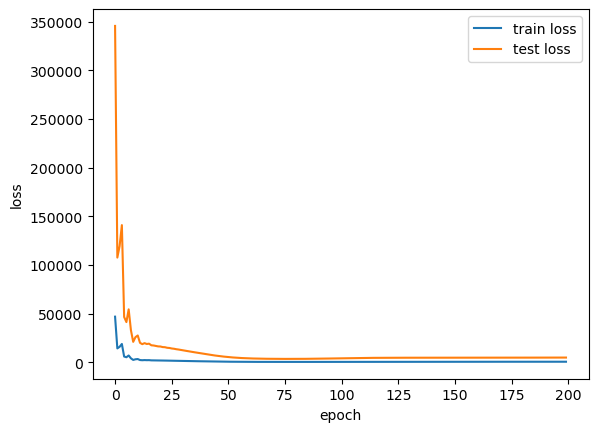

In [127]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

6. 预测并对比

In [128]:
def predict(x):
    # 将输入数据从 DataFrame 转换为 NumPy 数组
    if isinstance(x, pd.DataFrame):
        x = x.values
    temp = torch.from_numpy(x).double().squeeze(1)  # 将数据类型转换为 Double
    # print('temp:', temp.shape)
    x_tensor = temp.reshape(1, 1, window_size-1)  # (batch_size, feature_size)
    # print('x_tensor:', x_tensor.shape)
    return net1(x_tensor)

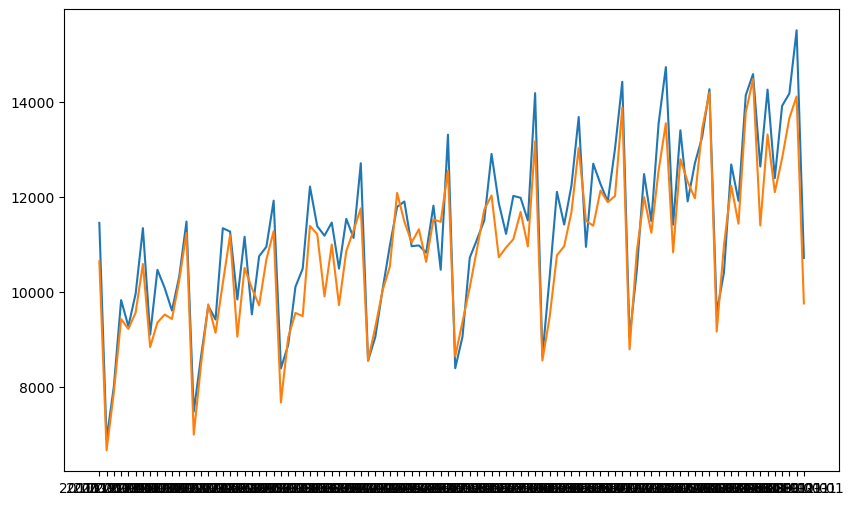

In [130]:
test_predict = []
split_point = int(split_prop * int(data.size))
# 针对测试集中的数据，按照滑窗大小取出特征，利用训练好的网络预测下一个值
for i in range((split_point - (window_size-1)), (data.size - (window_size-1))):
    x = data[i:(i + window_size-1)]
    y = predict(x)
    y = y.detach().numpy().squeeze()
    test_predict.append(y)
# 将测试集真实数据与网络预测数据以不同颜色绘制在一起，便于对比
plt.figure(figsize=(10, 6))
plt.plot(test)
plt.plot(test_predict)

In [111]:
from sklearn.metrics import mean_squared_error as mse

print('MSE:', mse(test, test_predict))

MSE: 424379.54742596566


learning rate = 0.01

构建3层前馈神经网络

In [131]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)
    
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 12, 1, 3

# 定义模型
net2 = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

In [132]:
# 参数初始化
for params in net2.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    
lr = 0.01
num_epochs = 200
batch_size = 64
loss = squared_loss
# loss = nn.MSELoss() # 均方误差损失函数
optimizer = torch.optim.Adam(net2.parameters(), lr=lr) # Adam优化器

训练模型

In [133]:
train_loss = []
test_loss = []

# 模型训练
for epoch in range(num_epochs): # 外循环训练一轮
    train_l, test_l = 0.0, 0.0
    for X, y in data_iter(batch_size, train_feature, train_label): # 内循环训练一个batch
        X = X.double()  
        y = y.double()  
        y_hat = net2(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        
    # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）
    train_feature = train_feature.double()  
    train_label = train_label.double()  
    test_feature = test_feature.double() 
    test_label = test_label.double()  
    train_l = loss(net2(train_feature), train_label).mean().item()
    test_l = loss(net2(test_feature), test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))

epoch 0, train loss 201191.839369, test loss 1468529.645625
epoch 1, train loss 161207.063291, test loss 1177100.248304
epoch 2, train loss 100417.236990, test loss 734039.180130
epoch 3, train loss 36870.319405, test loss 270922.820156
epoch 4, train loss 3188.320900, test loss 25561.816350
epoch 5, train loss 15292.273915, test loss 113956.351079
epoch 6, train loss 20361.206259, test loss 150927.061250
epoch 7, train loss 6743.638013, test loss 51568.364188
epoch 8, train loss 2836.968050, test loss 22994.260412
epoch 9, train loss 6196.700885, test loss 47433.334866
epoch 10, train loss 6467.094033, test loss 49397.236675
epoch 11, train loss 3764.385719, test loss 29718.608148
epoch 12, train loss 2595.289677, test loss 21228.535262
epoch 13, train loss 3240.299397, test loss 25947.642447
epoch 14, train loss 3136.709566, test loss 25183.202419
epoch 15, train loss 2604.963154, test loss 21281.493057
epoch 16, train loss 2692.674201, test loss 21897.202212
epoch 17, train loss 283

5. 绘制损失函数Loss曲线

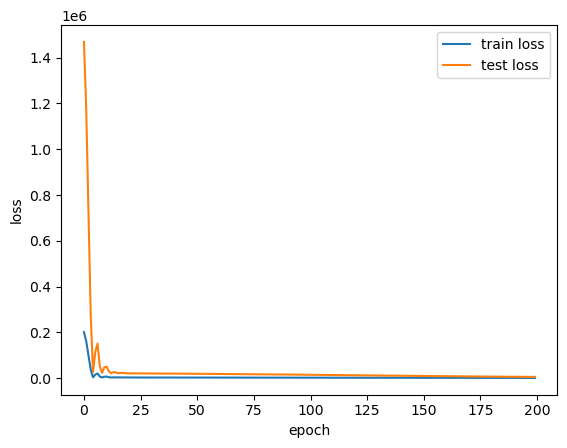

In [134]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

6. 预测并对比

In [135]:
def predict(x):
    # 将输入数据从 DataFrame 转换为 NumPy 数组
    if isinstance(x, pd.DataFrame):
        x = x.values
    temp = torch.from_numpy(x).double().squeeze(1)  # 将数据类型转换为 Double
    # print('temp:', temp.shape)
    x_tensor = temp.reshape(1, 1, window_size-1)  # (batch_size, feature_size)
    # print('x_tensor:', x_tensor.shape)
    return net2(x_tensor)

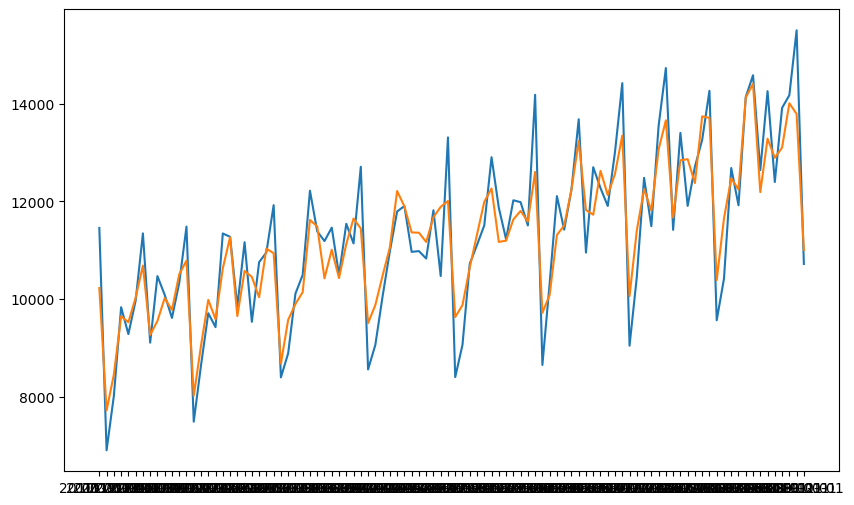

In [136]:
test_predict = []
split_point = int(split_prop * int(data.size))
# 针对测试集中的数据，按照滑窗大小取出特征，利用训练好的网络预测下一个值
for i in range((split_point - (window_size-1)), (data.size - (window_size-1))):
    x = data[i:(i + window_size-1)]
    y = predict(x)
    y = y.detach().numpy().squeeze()
    test_predict.append(y)
# 将测试集真实数据与网络预测数据以不同颜色绘制在一起，便于对比
plt.figure(figsize=(10, 6))
plt.plot(test)
plt.plot(test_predict)

In [137]:
from sklearn.metrics import mean_squared_error as mse

print('MSE:', mse(test, test_predict))

MSE: 431660.04566043126


learning rate = 0.001

构建3层前馈神经网络

In [138]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)
    
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 12, 1, 3

# 定义模型
net3 = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

In [139]:
# 参数初始化
for params in net3.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    
lr = 0.001
num_epochs = 100
batch_size = 64
# loss = squared_loss
loss = nn.MSELoss() # 均方误差损失函数
optimizer = torch.optim.Adam(net3.parameters(), lr=lr) # Adam优化器

训练模型

In [140]:
train_loss = []
test_loss = []

# 模型训练
for epoch in range(num_epochs): # 外循环训练一轮
    train_l, test_l = 0.0, 0.0
    for X, y in data_iter(batch_size, train_feature, train_label): # 内循环训练一个batch
        X = X.double()  
        y = y.double()  
        y_hat = net3(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        
    # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）
    train_feature = train_feature.double()  
    train_label = train_label.double()  
    test_feature = test_feature.double() 
    test_label = test_label.double()  
    train_l = loss(net3(train_feature), train_label).mean().item()
    test_l = loss(net3(test_feature), test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([215])) that is different to the input size (torch.Size([215, 1])). This will likely lead to incorrect results due to broadcas

epoch 0, train loss 46354497.243878, test loss 135325995.676292
epoch 1, train loss 46354444.935925, test loss 135325903.610690
epoch 2, train loss 46354392.628244, test loss 135325811.545543
epoch 3, train loss 46354340.319973, test loss 135325719.479332
epoch 4, train loss 46354288.010891, test loss 135325627.411670
epoch 5, train loss 46354235.700953, test loss 135325535.342478
epoch 6, train loss 46354183.390184, test loss 135325443.271797
epoch 7, train loss 46354131.078634, test loss 135325351.199719
epoch 8, train loss 46354078.766369, test loss 135325259.126357
epoch 9, train loss 46354026.453457, test loss 135325167.051834
epoch 10, train loss 46353974.139968, test loss 135325074.976269
epoch 11, train loss 46353921.825965, test loss 135324982.899774
epoch 12, train loss 46353869.511506, test loss 135324890.822455
epoch 13, train loss 46353817.196645, test loss 135324798.744403
epoch 14, train loss 46353764.881430, test loss 135324706.665703
epoch 15, train loss 46353712.56590

5. 绘制损失函数Loss曲线

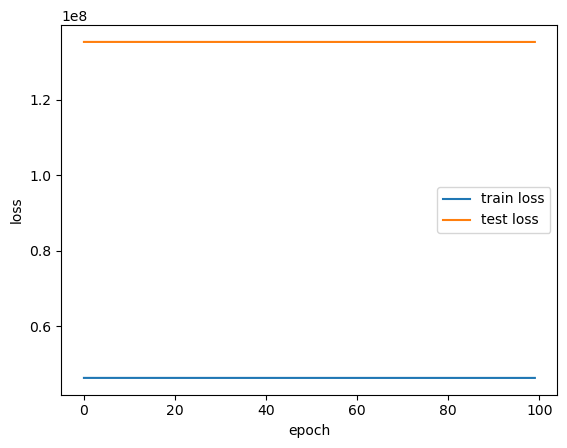

In [141]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

6. 预测并对比

In [142]:
def predict(x):
    # 将输入数据从 DataFrame 转换为 NumPy 数组
    if isinstance(x, pd.DataFrame):
        x = x.values
    temp = torch.from_numpy(x).double().squeeze(1)  # 将数据类型转换为 Double
    # print('temp:', temp.shape)
    x_tensor = temp.reshape(1, 1, window_size-1)  # (batch_size, feature_size)
    # print('x_tensor:', x_tensor.shape)
    return net3(x_tensor)

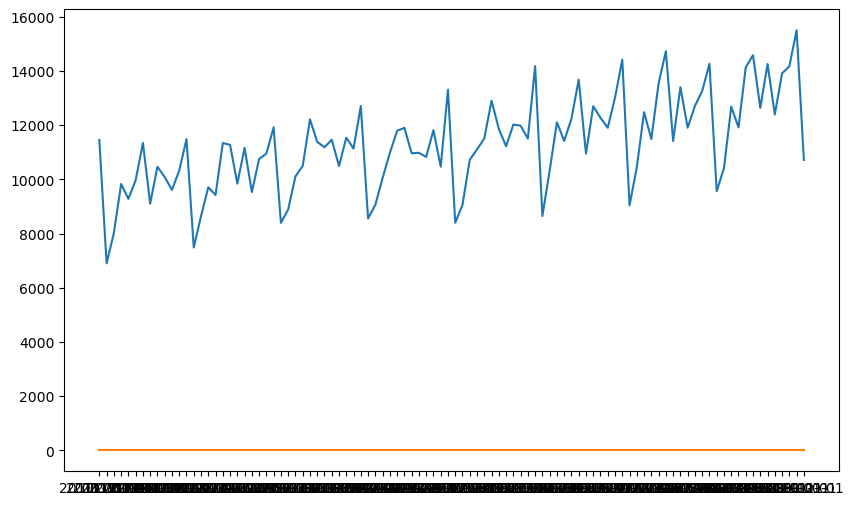

In [143]:
test_predict = []
split_point = int(split_prop * int(data.size))
# 针对测试集中的数据，按照滑窗大小取出特征，利用训练好的网络预测下一个值
for i in range((split_point - (window_size-1)), (data.size - (window_size-1))):
    x = data[i:(i + window_size-1)]
    y = predict(x)
    y = y.detach().numpy().squeeze()
    test_predict.append(y)
# 将测试集真实数据与网络预测数据以不同颜色绘制在一起，便于对比
plt.figure(figsize=(10, 6))
plt.plot(test)
plt.plot(test_predict)

In [144]:
from sklearn.metrics import mean_squared_error as mse

print('MSE:', mse(test, test_predict))

MSE: 130452417.33508167


### 从结果来看，神经网络的拟合效果很差。三种学习率的结果都很差

### 使用SVR进行回归预测

In [145]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse

model = SVR(kernel='linear')
# 模型训练
model.fit(train_feature, train_label)
# 测试集预测
test_predict = model.predict(test_feature)
# 计算mse
mse = mse(test_label, test_predict)

print('使用SVR模型的测试集最终MSE:', mse)

使用SVR模型的测试集最终MSE: 307704.0222238558


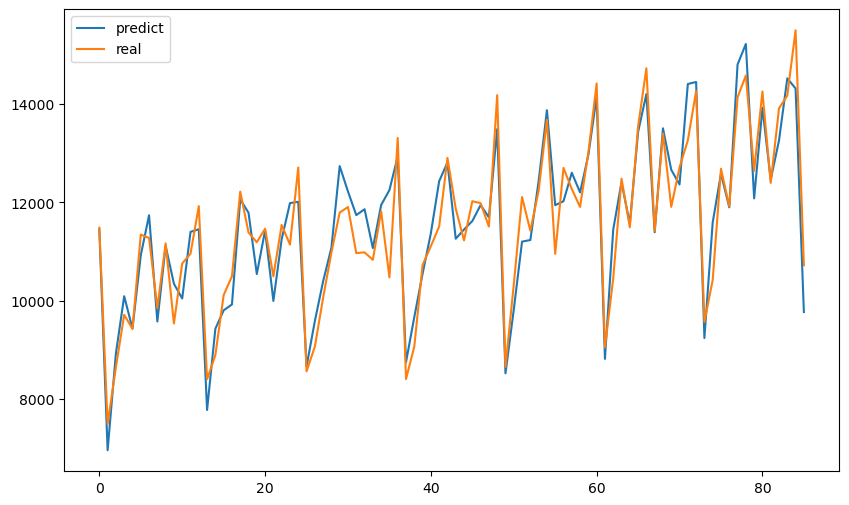

In [146]:
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(test_predict, label='predict')
plt.plot(test_label, label = 'real')
plt.legend()

In [147]:
from sklearn.metrics import mean_squared_error as mse

print('MSE:', mse(test_label, test_predict))

MSE: 307704.0222238558


### 使用决策树

In [148]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

model = DecisionTreeRegressor()
# 模型训练
model.fit(train_feature, train_label)
# 测试集预测
test_predict = model.predict(test_feature)
# 计算mse
mse = mse(test_label, test_predict)

print('使用决策树模型的测试集最终MSE:', mse)

使用决策树模型的测试集最终MSE: 4172175.069767442


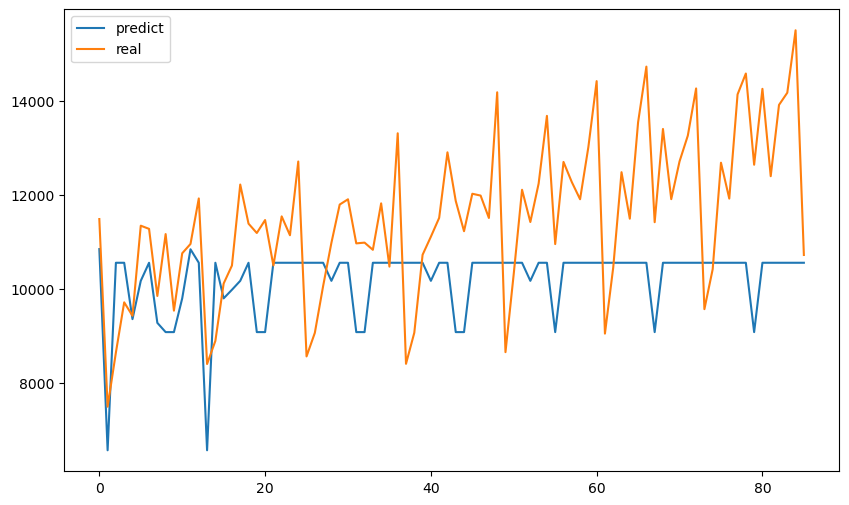

In [149]:
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(test_predict, label='predict')
plt.plot(test_label, label = 'real')
plt.legend()

In [150]:
from sklearn.metrics import mean_squared_error as mse

print('MSE:', mse(test_label, test_predict))

MSE: 4172175.069767442


### 由此发现，机器学习模型的拟合效果要比神经网络模型拟合效果更好。同时，采用支持向量回归，并且当采用线性核的时候，模型的拟合效果最好。